In [2]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

# Charger les données
X, y = load_breast_cancer(return_X_y=True)

# Conversion en float
X = X.astype(float)
y = y.astype(float)  # 0 ou 1

# Standardisation (très importante pour l’optimisation)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Ajout du biais (intercept)
X = np.c_[np.ones((X.shape[0], 1)), X]

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Taux de positifs:", y.mean())


X shape: (569, 31)
y shape: (569,)
Taux de positifs: 0.6274165202108963


n=569, d=31, approx ||X||_2=86.9324, Lipschitz L≈3.320502, pas alpha≈0.301159

=== Run GD (pas fixe) ===
[GD] iter=   0  loss=0.693147  ||g||=1.418e+00
[GD] iter=  50  loss=0.090816  ||g||=4.001e-02
[GD] iter= 100  loss=0.076676  ||g||=2.371e-02
[GD] iter= 150  loss=0.070429  ||g||=1.755e-02
[GD] iter= 200  loss=0.066675  ||g||=1.422e-02
[GD] iter= 250  loss=0.064089  ||g||=1.208e-02
[GD] iter= 300  loss=0.062166  ||g||=1.057e-02
[GD] iter= 350  loss=0.060663  ||g||=9.437e-03
[GD] iter= 400  loss=0.059448  ||g||=8.547e-03
[GD] iter= 450  loss=0.058440  ||g||=7.826e-03
[GD] iter= 499  loss=0.057604  ||g||=7.239e-03

=== Run CG (Newton gelé au point initial) ===
[CG] done in 64 iters | loss=0.237738 | ||grad||=3.939e-01 | time=0.010s


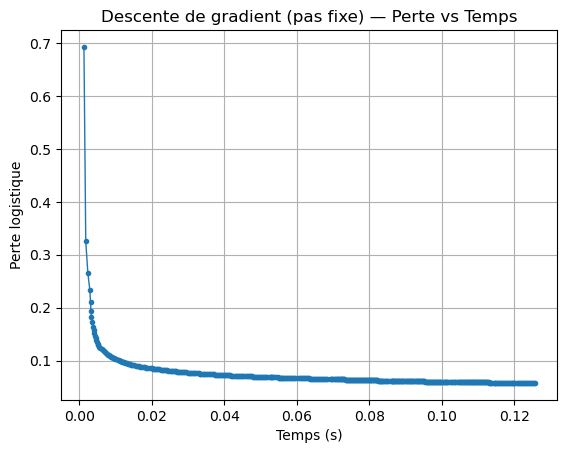

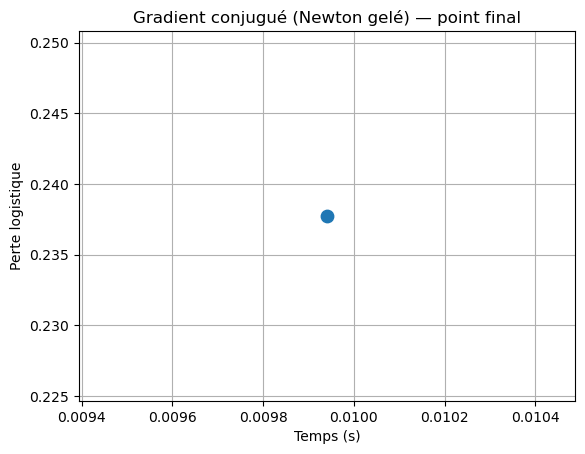

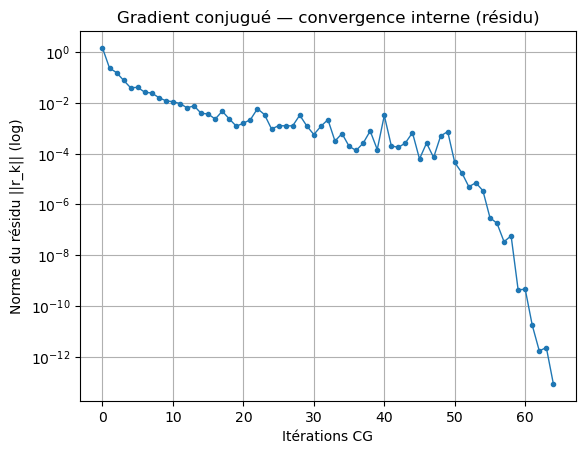


=== Résumé ===
GD final:  loss=0.057604, ||grad||=7.239e-03, time=0.126s, iters=499
CG final:  loss=0.237738, ||grad||=3.939e-01, time=0.010s, iters=64


In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt

# ============================================================
# 0) Données : Breast Cancer Wisconsin (sklearn autorisé ici)
# ============================================================
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

X, y = load_breast_cancer(return_X_y=True)
X = X.astype(float)
y = y.astype(float)  # 0/1

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Biais (intercept)
X = np.c_[np.ones((X.shape[0], 1)), X]  # (n, d)
n, d = X.shape

# ============================================================
# 1) Outils : sigmoid stable + perte logistique + grad + hess
# ============================================================
def sigmoid(z):
    # stable
    z = np.clip(z, -50, 50)
    return 1.0 / (1.0 + np.exp(-z))

def logistic_loss(w, X, y, lam=0.0):
    """
    f(w) = (1/n) sum log(1 + exp(x_i^T w)) - y_i x_i^T w  + (lam/2)||w||^2
    """
    z = X @ w
    z = np.clip(z, -50, 50)
    # log(1+exp(z)) stable
    log1pexp = np.log1p(np.exp(z))
    loss = np.mean(log1pexp - y * z)
    if lam > 0:
        loss += 0.5 * lam * np.dot(w, w)
    return loss

def logistic_grad(w, X, y, lam=0.0):
    p = sigmoid(X @ w)
    g = (X.T @ (p - y)) / X.shape[0]
    if lam > 0:
        g = g + lam * w
    return g

def logistic_hess(w, X, lam=0.0):
    """
    Hessien : (1/n) X^T S X + lam I, avec S = diag(p(1-p))
    """
    p = sigmoid(X @ w)
    s = p * (1.0 - p)  # (n,)
    # Calcul de X^T (S X) sans former diag(S)
    XS = X * s[:, None]          # (n,d)
    H = (X.T @ XS) / X.shape[0]  # (d,d)
    if lam > 0:
        H = H + lam * np.eye(X.shape[1])
    return H

# ============================================================
# 2) Lipschitz (pour choisir un pas fixe) : L = (1/4n)||X||_2^2 + lam
#    (car max p(1-p) <= 1/4)
# ============================================================
def spectral_norm_estimate(A, n_iter=50, seed=0):
    rng = np.random.default_rng(seed)
    v = rng.normal(size=A.shape[1])
    v /= np.linalg.norm(v)
    for _ in range(n_iter):
        v = A.T @ (A @ v)
        nv = np.linalg.norm(v)
        if nv == 0:
            return 0.0
        v /= nv
    # Rayleigh quotient gives ||A||_2^2 approx for A^T A
    Av = A @ v
    return np.linalg.norm(Av)

lam = 1e-4  # petite régularisation L2 pour stabiliser (optionnel)
X_norm2 = spectral_norm_estimate(X, n_iter=60, seed=0)  # approx ||X||_2
L = (X_norm2**2) * (0.25 / n) + lam
alpha = 1.0 / L  # pas fixe conseillé

print(f"n={n}, d={d}, approx ||X||_2={X_norm2:.4f}, Lipschitz L≈{L:.6f}, pas alpha≈{alpha:.6f}")

# ============================================================
# 3) Descente de gradient à pas fixe
# ============================================================
def gradient_descent_fixed_step(X, y, lam, alpha, max_iter=500, tol=1e-8, w0=None, verbose=True):
    if w0 is None:
        w = np.zeros(X.shape[1])
    else:
        w = w0.copy()

    hist = {"iter": [], "loss": [], "grad_norm": [], "time": []}
    t0 = time.time()

    for k in range(max_iter):
        f = logistic_loss(w, X, y, lam)
        g = logistic_grad(w, X, y, lam)
        ng = np.linalg.norm(g)

        hist["iter"].append(k)
        hist["loss"].append(f)
        hist["grad_norm"].append(ng)
        hist["time"].append(time.time() - t0)

        if verbose and (k % 50 == 0 or k == max_iter - 1):
            print(f"[GD] iter={k:4d}  loss={f:.6f}  ||g||={ng:.3e}")

        if ng < tol:
            break

        w = w - alpha * g

    return w, hist

# ============================================================
# 4) Gradient Conjugué (CG) : résolution A p = b
#    Ici on compare à GD sur le QUADRATIQUE local:
#    Minimiser q(w) = 1/2 w^T H0 w + g0^T w
#    => solution w* = - H0^{-1} g0  (si H0 SPD)
#
#    On fait CG sur H0 p = -g0 et on prend w = w0 + p
# ============================================================
def conjugate_gradient(A, b, max_iter=200, tol=1e-10):
    """
    Résout A x = b (A SPD) par CG.
    Retourne x et historique (résidu).
    """
    x = np.zeros_like(b)
    r = b - A @ x
    p = r.copy()
    rs_old = r @ r

    res_hist = [np.sqrt(rs_old)]
    for k in range(max_iter):
        Ap = A @ p
        denom = p @ Ap
        if denom <= 1e-30:
            break
        alpha = rs_old / denom
        x = x + alpha * p
        r = r - alpha * Ap
        rs_new = r @ r
        res_hist.append(np.sqrt(rs_new))
        if np.sqrt(rs_new) < tol:
            break
        p = r + (rs_new / rs_old) * p
        rs_old = rs_new

    return x, res_hist

def cg_newton_frozen(X, y, lam, w0=None, cg_max_iter=200, cg_tol=1e-10, verbose=True):
    """
    Compare CG via Hessien gelé au point initial w0:
    H0 = Hess(w0), g0 = grad(w0).
    Solve H0 p = -g0, set w = w0 + p.
    """
    if w0 is None:
        w0 = np.zeros(X.shape[1])

    t0 = time.time()
    g0 = logistic_grad(w0, X, y, lam)
    H0 = logistic_hess(w0, X, lam)

    # CG solve
    p, res_hist = conjugate_gradient(H0, -g0, max_iter=cg_max_iter, tol=cg_tol)
    w = w0 + p

    elapsed = time.time() - t0
    f = logistic_loss(w, X, y, lam)
    ng = np.linalg.norm(logistic_grad(w, X, y, lam))

    if verbose:
        print(f"[CG] done in {len(res_hist)-1} iters | loss={f:.6f} | ||grad||={ng:.3e} | time={elapsed:.3f}s")

    hist = {
        "cg_residual": res_hist,
        "time": elapsed,
        "loss": f,
        "grad_norm": ng
    }
    return w, hist

# ============================================================
# 5) Run + comparaison
# ============================================================
w0 = np.zeros(d)

print("\n=== Run GD (pas fixe) ===")
w_gd, hist_gd = gradient_descent_fixed_step(X, y, lam, alpha, max_iter=500, tol=1e-7, w0=w0, verbose=True)

print("\n=== Run CG (Newton gelé au point initial) ===")
w_cg, hist_cg = cg_newton_frozen(X, y, lam, w0=w0, cg_max_iter=200, cg_tol=1e-12, verbose=True)

# ============================================================
# 6) Courbes : perte vs temps (demandé)
# ============================================================
plt.figure()
plt.plot(hist_gd["time"], hist_gd["loss"], marker="o", markersize=3, linewidth=1)
plt.xlabel("Temps (s)")
plt.ylabel("Perte logistique")
plt.title("Descente de gradient (pas fixe) — Perte vs Temps")
plt.grid(True)
plt.show()

# Un point pour CG (car ici CG résout un sous-problème en une fois)
plt.figure()
plt.scatter([hist_cg["time"]], [hist_cg["loss"]], s=80)
plt.xlabel("Temps (s)")
plt.ylabel("Perte logistique")
plt.title("Gradient conjugué (Newton gelé) — point final")
plt.grid(True)
plt.show()

# Option : résidu CG par itération
plt.figure()
plt.semilogy(hist_cg["cg_residual"], marker="o", markersize=3, linewidth=1)
plt.xlabel("Itérations CG")
plt.ylabel("Norme du résidu ||r_k|| (log)")
plt.title("Gradient conjugué — convergence interne (résidu)")
plt.grid(True)
plt.show()

# ============================================================
# 7) Petit résumé numérique
# ============================================================
print("\n=== Résumé ===")
print(f"GD final:  loss={hist_gd['loss'][-1]:.6f}, ||grad||={hist_gd['grad_norm'][-1]:.3e}, time={hist_gd['time'][-1]:.3f}s, iters={hist_gd['iter'][-1]}")
print(f"CG final:  loss={hist_cg['loss']:.6f}, ||grad||={hist_cg['grad_norm']:.3e}, time={hist_cg['time']:.3f}s, iters={len(hist_cg['cg_residual'])-1}")


n=569, d=31, ||X||_2≈86.9324, L≈3.320502, alpha≈0.301159


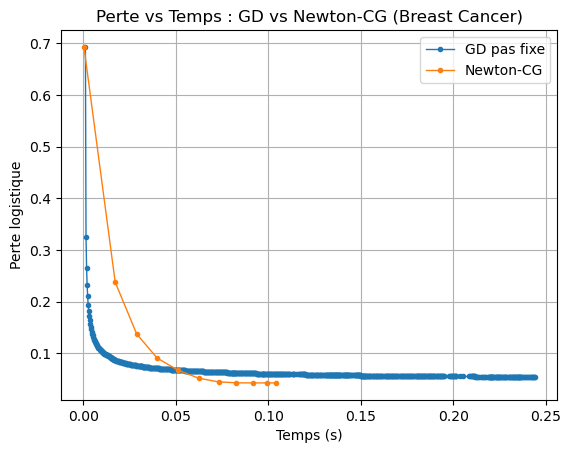

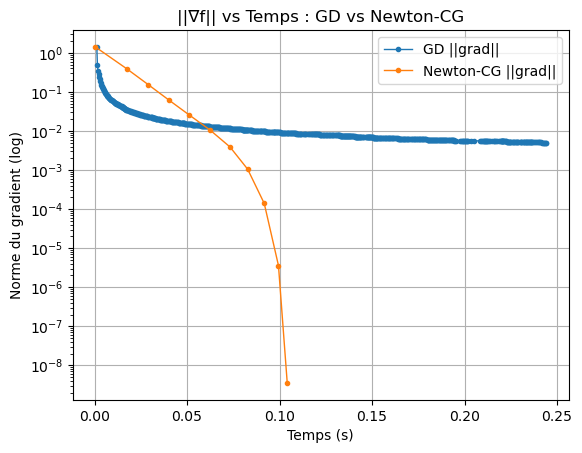


=== Résumé ===
GD :   iters=800,  loss_final=0.054322,  ||g||=5.039e-03,  time=0.244s
NCG:  iters=11, loss_final=0.042656, ||g||=3.556e-09, time=0.104s
Newton-CG : CG iters par itération = [59, 58, 56, 55, 55, 51, 47, 41, 38, 30, 0]


In [4]:
import numpy as np
import time
import matplotlib.pyplot as plt

# ============================================================
# 0) Données : Breast Cancer Wisconsin (sklearn autorisé ici)
# ============================================================
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

X, y = load_breast_cancer(return_X_y=True)
X = X.astype(float)
y = y.astype(float)  # 0/1

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Ajouter biais (intercept)
X = np.c_[np.ones((X.shape[0], 1)), X]
n, d = X.shape

# ============================================================
# 1) Logistique (stable) : perte + gradient + Hessien-vecteur
# ============================================================
def sigmoid(z):
    z = np.clip(z, -50, 50)
    return 1.0 / (1.0 + np.exp(-z))

def logistic_loss(w, X, y, lam=0.0):
    z = X @ w
    z = np.clip(z, -50, 50)
    log1pexp = np.log1p(np.exp(z))       # log(1+exp(z))
    f = np.mean(log1pexp - y * z)
    if lam > 0:
        f += 0.5 * lam * np.dot(w, w)
    return f

def logistic_grad(w, X, y, lam=0.0):
    p = sigmoid(X @ w)
    g = (X.T @ (p - y)) / X.shape[0]
    if lam > 0:
        g = g + lam * w
    return g

def hvp_logistic(w, v, X, y, lam=0.0):
    """
    Hessian-vector product: H(w) v = (1/n) X^T (s * (Xv)) + lam v
    avec s = p(1-p).
    """
    p = sigmoid(X @ w)
    s = p * (1.0 - p)                    # (n,)
    Xv = X @ v                           # (n,)
    Hv = (X.T @ (s * Xv)) / X.shape[0]   # (d,)
    if lam > 0:
        Hv = Hv + lam * v
    return Hv

# ============================================================
# 2) Lipschitz L (pour pas fixe GD) : L <= (1/4n)||X||^2 + lam
# ============================================================
def spectral_norm_estimate(A, n_iter=60, seed=0):
    rng = np.random.default_rng(seed)
    v = rng.normal(size=A.shape[1])
    v /= np.linalg.norm(v)
    for _ in range(n_iter):
        v = A.T @ (A @ v)
        nv = np.linalg.norm(v)
        if nv == 0:
            return 0.0
        v /= nv
    Av = A @ v
    return np.linalg.norm(Av)

lam = 1e-4
X_norm2 = spectral_norm_estimate(X, n_iter=60, seed=0)  # approx ||X||_2
L = (X_norm2**2) * (0.25 / n) + lam
alpha = 1.0 / L

print(f"n={n}, d={d}, ||X||_2≈{X_norm2:.4f}, L≈{L:.6f}, alpha≈{alpha:.6f}")

# ============================================================
# 3) Descente de gradient à pas fixe
# ============================================================
def gradient_descent_fixed_step(X, y, lam, alpha, max_iter=500, tol=1e-7, w0=None):
    w = np.zeros(X.shape[1]) if w0 is None else w0.copy()
    hist = {"time": [], "loss": [], "grad_norm": []}
    t0 = time.time()

    for k in range(max_iter):
        f = logistic_loss(w, X, y, lam)
        g = logistic_grad(w, X, y, lam)
        ng = np.linalg.norm(g)

        hist["time"].append(time.time() - t0)
        hist["loss"].append(f)
        hist["grad_norm"].append(ng)

        if ng < tol:
            break

        w = w - alpha * g

    return w, hist

# ============================================================
# 4) CG (matrice implicite via Hessien-vecteur)
# ============================================================
def conjugate_gradient_implicit(Avp, b, max_iter=200, tol=1e-10):
    """
    Résout A x = b par CG, A SPD, sans former A.
    Avp(x) doit renvoyer A@x.
    """
    x = np.zeros_like(b)
    r = b - Avp(x)
    p = r.copy()
    rs_old = r @ r
    res_hist = [np.sqrt(rs_old)]

    for k in range(max_iter):
        Ap = Avp(p)
        denom = p @ Ap
        if denom <= 1e-30:
            break
        alpha = rs_old / denom
        x = x + alpha * p
        r = r - alpha * Ap
        rs_new = r @ r
        res_hist.append(np.sqrt(rs_new))
        if np.sqrt(rs_new) < tol:
            break
        p = r + (rs_new / rs_old) * p
        rs_old = rs_new

    return x, res_hist

# ============================================================
# 5) Newton-CG (non linéaire)
# ============================================================
def newton_cg(X, y, lam, max_iter=50, tol=1e-7,
              cg_max_iter=200, cg_tol=1e-10,
              line_search=True, w0=None):
    w = np.zeros(X.shape[1]) if w0 is None else w0.copy()

    hist = {"time": [], "loss": [], "grad_norm": [], "cg_iters": []}
    t0 = time.time()

    for k in range(max_iter):
        f = logistic_loss(w, X, y, lam)
        g = logistic_grad(w, X, y, lam)
        ng = np.linalg.norm(g)

        hist["time"].append(time.time() - t0)
        hist["loss"].append(f)
        hist["grad_norm"].append(ng)

        if ng < tol:
            hist["cg_iters"].append(0)
            break

        # solve H(w) p = -g with CG (implicit Hessian-vector product)
        Avp = lambda v: hvp_logistic(w, v, X, y, lam)
        p, res_hist = conjugate_gradient_implicit(Avp, -g, max_iter=cg_max_iter, tol=cg_tol)
        hist["cg_iters"].append(len(res_hist) - 1)

        # (optionnel) line search Armijo (stabilité)
        step = 1.0
        if line_search:
            c = 1e-4
            # condition de descente : f(w+tp) <= f(w) + c t g^T p
            gTp = g @ p
            if gTp > 0:  # sécurité : si pas non descendant, on inverse
                p = -p
                gTp = g @ p
            while True:
                w_new = w + step * p
                f_new = logistic_loss(w_new, X, y, lam)
                if f_new <= f + c * step * gTp:
                    break
                step *= 0.5
                if step < 1e-8:
                    break
            w = w_new
        else:
            w = w + p

    return w, hist

# ============================================================
# 6) Exécution + Courbes "Perte vs Temps"
# ============================================================
w0 = np.zeros(d)

w_gd, hist_gd = gradient_descent_fixed_step(X, y, lam, alpha, max_iter=800, tol=1e-7, w0=w0)
w_ncg, hist_ncg = newton_cg(X, y, lam, max_iter=50, tol=1e-7,
                           cg_max_iter=300, cg_tol=1e-10,
                           line_search=True, w0=w0)

plt.figure()
plt.plot(hist_gd["time"], hist_gd["loss"], marker="o", markersize=3, linewidth=1, label="GD pas fixe")
plt.plot(hist_ncg["time"], hist_ncg["loss"], marker="o", markersize=3, linewidth=1, label="Newton-CG")
plt.xlabel("Temps (s)")
plt.ylabel("Perte logistique")
plt.title("Perte vs Temps : GD vs Newton-CG (Breast Cancer)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.semilogy(hist_gd["time"], hist_gd["grad_norm"], marker="o", markersize=3, linewidth=1, label="GD ||grad||")
plt.semilogy(hist_ncg["time"], hist_ncg["grad_norm"], marker="o", markersize=3, linewidth=1, label="Newton-CG ||grad||")
plt.xlabel("Temps (s)")
plt.ylabel("Norme du gradient (log)")
plt.title("||∇f|| vs Temps : GD vs Newton-CG")
plt.grid(True)
plt.legend()
plt.show()

print("\n=== Résumé ===")
print(f"GD :   iters={len(hist_gd['loss'])},  loss_final={hist_gd['loss'][-1]:.6f},  ||g||={hist_gd['grad_norm'][-1]:.3e},  time={hist_gd['time'][-1]:.3f}s")
print(f"NCG:  iters={len(hist_ncg['loss'])}, loss_final={hist_ncg['loss'][-1]:.6f}, ||g||={hist_ncg['grad_norm'][-1]:.3e}, time={hist_ncg['time'][-1]:.3f}s")
print(f"Newton-CG : CG iters par itération = {hist_ncg['cg_iters']}")
